# Introduction

The task-TCN initially transforms the discrete task ID through an embedding layer. Ideally, in this **embedding space**, similar tasks should be close to one another. However, in contrast to the task embedding for MLPs an additional transformation takes place, which results in a **transformed embedding space**. In particular, the embedding space is transformed through a 1D convolution. The results of this transformation is added to the output of the residual block. By adding the results of this convolution we essentially add a bias to each channel, depending on the relation between tasks.

For instance consider, the output of the first residual block has 100 channels for 24 timestemps. For a single sample the dimension will be $1\times100\times24$. Also consider each task has an embedding vector of dimension $1 \times 10$. The embedding tensor will be then $1\times10\times24$. After applying the transformation, through the 1D convolution, the transformed embedding tensor will be also of dimension $1\times100\times24$.

In the following, we visually inspect features of those spaces and compare them with each other.

# Set-Up

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import torch
from fastai.learner import load_learner
from fastcore.foundation import L
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

In [25]:
sns.set()
sns.color_palette("colorblind", 8)
# sns.set_context("poster")
sns.set_style("whitegrid")
mpl.rcParams["legend.loc"] = "upper right"
FONT_SIZE = 25
params = {
    "axes.labelsize": FONT_SIZE,  # fontsize for x and y labels (was 10)
    "axes.titlesize": FONT_SIZE,
    "font.size": FONT_SIZE,  # was 10
    "legend.fontsize": FONT_SIZE,  # was 10
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,
    "font.family": "Times New Roman",

}
mpl.rcParams.update(params)

In [26]:
torch.set_grad_enabled(False)

In [27]:
source_model_file = "/home/scribbler/workspace/convolutional_transfer/results/2015_wind/tcn_source_model_False_0_EmbeddingType.Normal_residuals_first.pkl"
# source_model_file = "/mnt/work/transfer//2015_wind/tcn_source_model_False_0_EmbeddingType.Normal_residuals_first.pkl"
learner = load_learner(source_model_file)
model = learner.model

In [28]:
num_timestamps = 96
temporal_block_id = 0
embedding_layer = model.embedding_module.embeddings[0]
max_task_id = embedding_layer.weight.shape[0]
embedding_transform = learner.model.layers.temporal_blocks[
        temporal_block_id
    ].embedding_transform

In [29]:
model

TemporalCNN(
  (embedding_module): EmbeddingModule(
    (embeddings): ModuleList(
      (0): Embedding(37, 12)
    )
  )
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): TemporalConvNet(
    (temporal_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(7, 140, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (act_func1): ReLU()
        (dropout1): Dropout2d(p=0, inplace=False)
        (conv2): Conv1d(140, 140, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (act_func2): ReLU()
        (dropout2): Dropout2d(p=0, inplace=False)
        (net): Sequential(
          (0): Conv1d(7, 140, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout2d(p=0, inplace=False)
          (4): Conv1d(140, 140, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (

## Get (transformed) embeddings

Embedding of embedding layer:

In [30]:
latent_embeddings = L()
for task_id in range(1, max_task_id):
    cur_embedding = embedding_layer(torch.tensor(task_id).long())
    latent_embeddings += cur_embedding.numpy()
    
latent_embeddings = np.array(latent_embeddings)

In [31]:
latent_embeddings.shape

(36, 12)

Transformed embedding per channel:

In [32]:
latent_channelwise_embeddings = L()
for task_id in range(1, max_task_id):
    cur_transformed_embedding_space = model._forward_embedding_module_same(
        torch.ones([1, 1, num_timestamps]).long() * task_id
    )
    cur_transformed_embedding_space = embedding_transform(
        cur_transformed_embedding_space
    )
    # batch_size, channels, num_timesteps
    latent_channelwise_embeddings += cur_transformed_embedding_space[0,:,0].numpy()
latent_channelwise_embeddings = np.array(latent_channelwise_embeddings)

In [33]:
latent_channelwise_embeddings.shape

(36, 140)

# Visualizeing the Embedding Spaces through t-SNE

In [34]:
def reduce_dimension(latent_embeddings):
    latent_embeddings_reduced = TSNE(n_components=2, 
                        # proxy for number of neares neighbours
                         perplexity=3, 
                         # leads often to more robust results
                         init="pca", 
                         random_state=21).fit_transform(latent_embeddings)
    return latent_embeddings_reduced


def reduce_and_plot_latent_space(latent_embeddings,c=None):
    latent_embeddings_reduced = reduce_dimension(latent_embeddings)
    plt.figure(figsize=(10,10))
    plt.scatter(latent_embeddings_reduced[:,0], latent_embeddings_reduced[:,1], c= c)
    for task_id in range(0, max_task_id-1):
        plt.text(latent_embeddings_reduced[task_id,0], latent_embeddings_reduced[task_id,1], s=str(task_id+1))

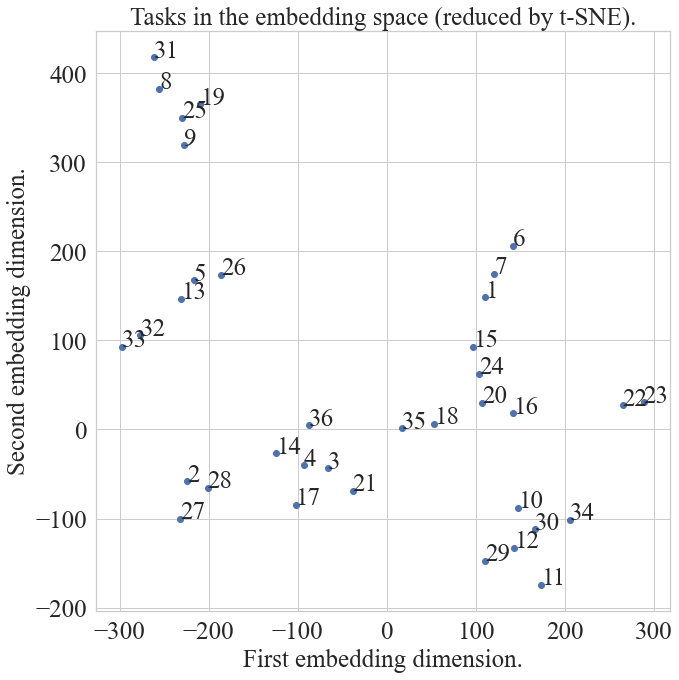

In [37]:
reduce_and_plot_latent_space(latent_embeddings)
plt.title("Tasks in the embedding space (reduced by t-SNE).")
plt.xlabel("First embedding dimension.")
plt.ylabel("Second embedding dimension.")
plt.tight_layout()
plt.savefig("../doc/figs/tsne_embedding_space.pdf")

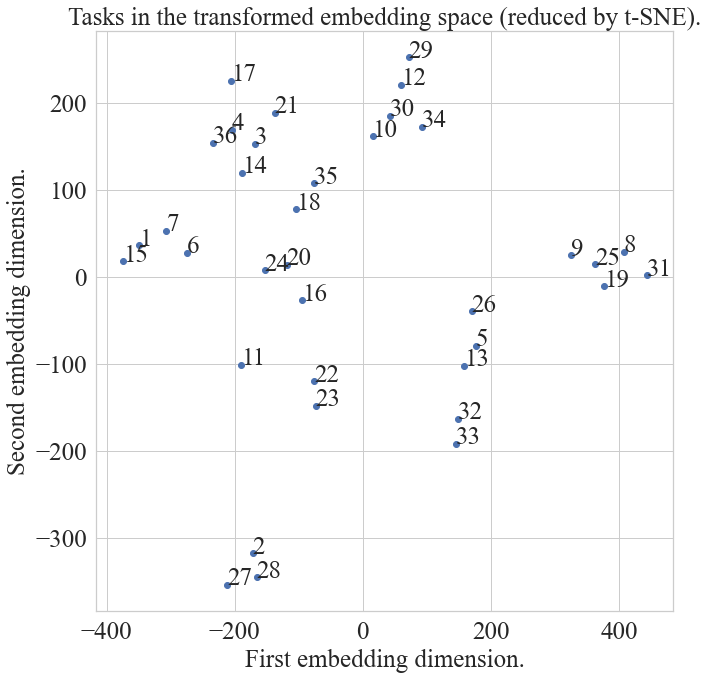

In [38]:
reduce_and_plot_latent_space(latent_channelwise_embeddings)
plt.title("Tasks in the transformed embedding space (reduced by t-SNE).")
plt.xlabel("First embedding dimension.")
plt.ylabel("Second embedding dimension.")
plt.tight_layout()
plt.savefig("../doc/figs/tsne_transformed_embedding_space.pdf")

Due to the transformation through t-SNE, we cannot directly compare the embedding and the transformed embedding space. However, we can visually verify if certrain tasks are close to one another in poth plots. For instance the tasks $29,12,30,10,$ and $34$ are always close to one another in both spaces. Even for multiplt runs of t-SNE. Similarly, $26,5,13,32,$ and $33$. A smaller distance is also present in various other clusters. However, some cannot be clustered easily. For instance task $11$ is close to $29,12,30,34,10$ in the embedding space. In the transformed embedding space, it is closest to $22,23,24,20$ and $16$. This potentially indicates that task $11$ is not similar to other tasks.

# Correlation between Embeddings Space and Channel Wise Embedding Space

To verify if the similarity between tasks in the embedding space is similar to the transformed embedding space, we calulate the euclidean distance for both latent spaces. Afterward, we create a scatter plot and calculate the pearson correlation to measure their linear dependency.

In [40]:
d1 = pdist(latent_embeddings, metric="euclidean")
d2 = pdist(latent_channelwise_embeddings, metric="euclidean")

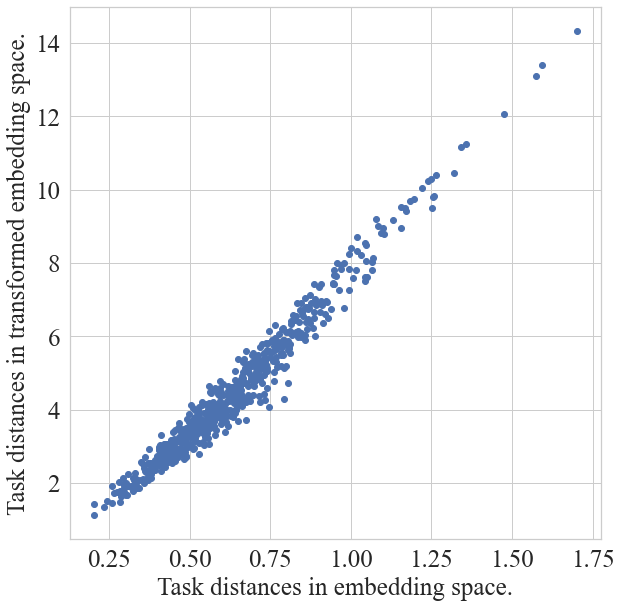

In [41]:
plt.figure(figsize=(9,9))
plt.scatter(d1, d2)
plt.xlabel("Task distances in embedding space.")
plt.ylabel("Task distances in transformed embedding space.")
plt.tight_layout()
plt.savefig("../doc/figs/corr_emb_trans.pdf")

In [16]:
pearson, _ = pearsonr(d2, d1)
pearson

0.9823221669228666

The pearson correlation above $0.9$ indicates a substantial linear dependency that is also visually available in the scatter plot. These results let us assume, that the learned similarity from the embedding space is not drastically changed through the transformation.

# Correlation between Tasks in the Tranformed Embedding Space

## Embedding Space as Baseline

To have a baseline of somilarities between tasks, we calculate the euclidean distance between each pair tasks in the embedding space. The results is visualised in the following heatmap. Larger values indicate a larger dissamilirity.

<AxesSubplot:>

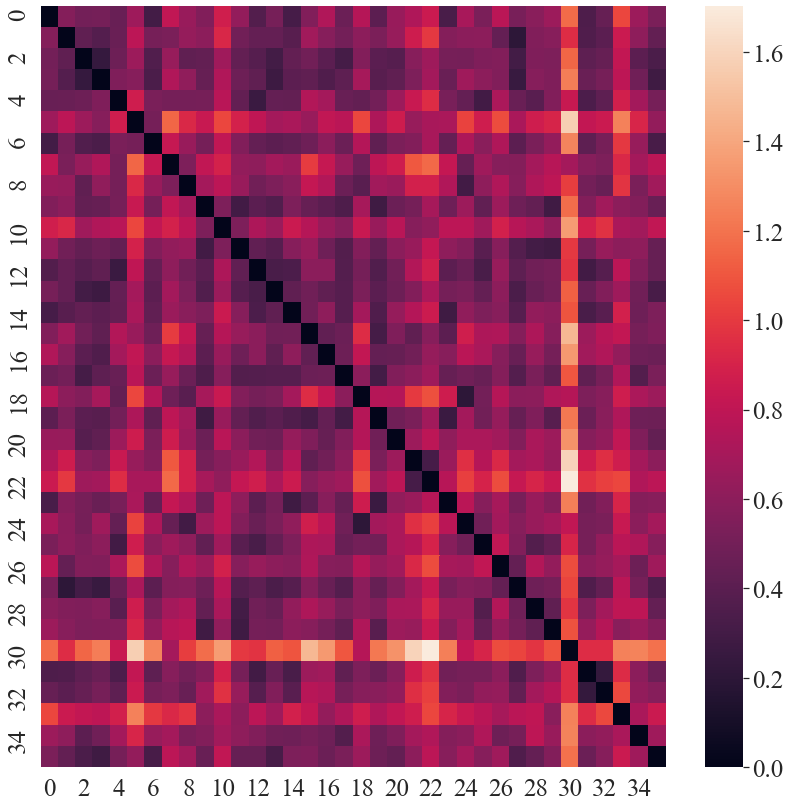

In [17]:
plt.figure(figsize=(14,14))
d = pdist(latent_embeddings)
sns.heatmap(squareform(d))

The tasks $5,10,21,30$ and $32$ seem to be the most dissimilar ones. This was not necessarily visible in the the scatter plot throguh t-SNE. 

Let us visualize, what distribution we have from the most similar parks.

<AxesSubplot:>

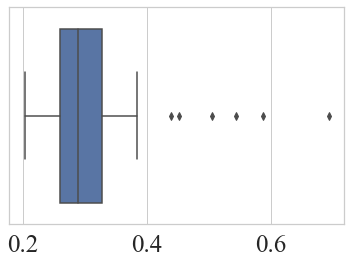

In [18]:
# find most similar task for each task and plot the distribution
sns.boxplot(np.sort(squareform(d))[:,1])

In the plot above, we can see that most tasks have an euclidean distance between $0.2$ and $0.4$ in the embedding space. However, there are also six outliers available that seem to be quite different to all other tasks.

## Mean Distance of Tasks from all Channels

In [19]:
num_channels = latent_channelwise_embeddings.shape[1]

In [20]:
squared_distances = L()
for channel in range(0, num_channels):
    d = pdist(latent_channelwise_embeddings[:,channel].reshape(-1,1),metric="euclidean")
    squared_distances += squareform(d)

mean_squared_distance = np.array(squared_distances).mean(0)
std_squared_distance = np.array(squared_distances).std(0)


<AxesSubplot:>

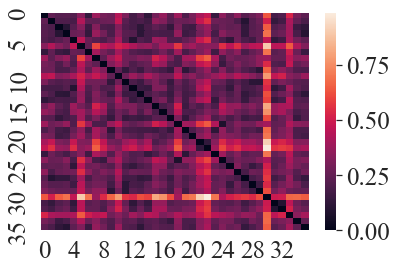

In [21]:
sns.heatmap(mean_squared_distance)

<AxesSubplot:>

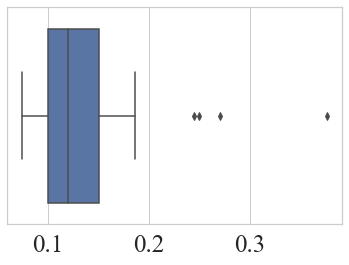

In [22]:
# find most similar task for each task and plot the distribution
sns.boxplot(np.sort(mean_squared_distance)[:,1])

In the above we visualize the minimum mean distance of all tasks and channels. In contrast to the embedding space, we have only four outliers.

## Distance between Tasks for each Channel

The following plots visualize the distance between tasks for each channel. Therefore, we calculate the euclidean distance for each tasks within a channel. So, we essentially measure the distance of the bias per channel. Interistingly, the similarities or rather dissimilarities between channels differ strongyl. For instance for channel $2$, there is a substantial difference of task $30$ to all other tasks. Comparing channel 2 with channel 3, we observe that this pattern is not visible. Instead there is a strong didsimilarity for the $20$ and $21$. Other channels such as $9,12$, and $12$ have a check-board like pattern, where we can observe groups of similarities and dissimilarities.

This lets assume that the the additional transformation is beneficial in learning complex similarities structures. We can assume, that specific channels are reponsible for different kind of weather situattions and terrain. Finanly, we can conclude that similarities are complex ones that needs to be modelled in a high dimensional space. In this way the additional transformation is beneficial so that the modell can learn different kind of features for different wether situatations while taking similarities of tasks into account.

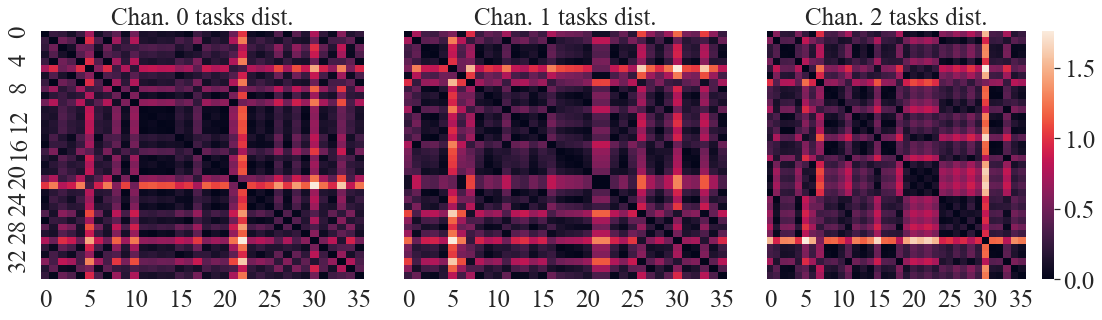

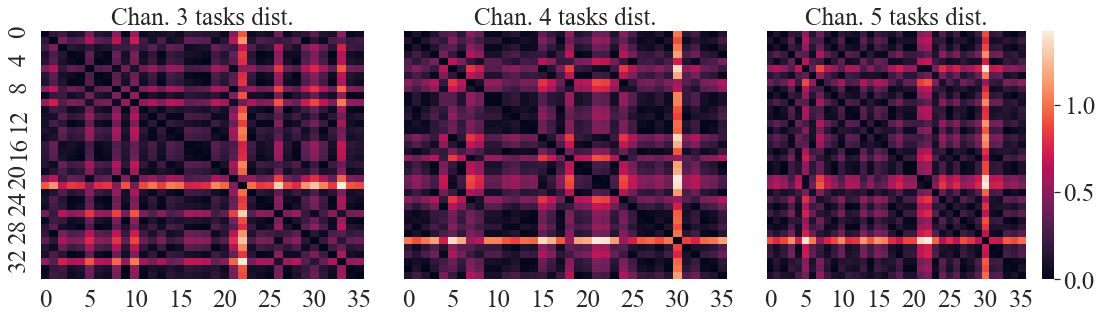

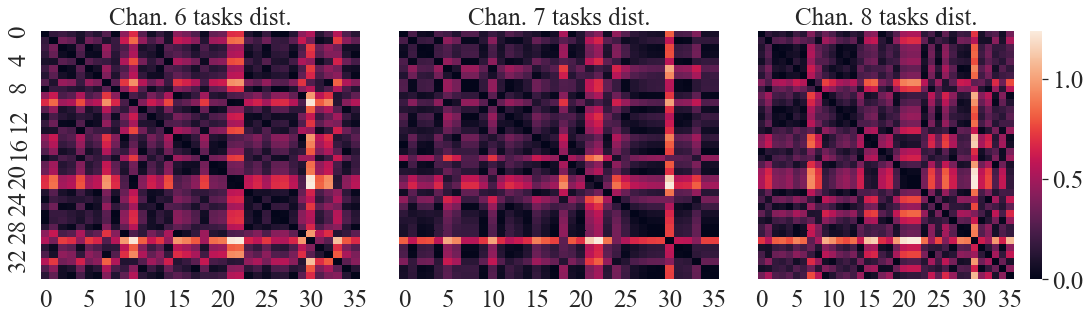

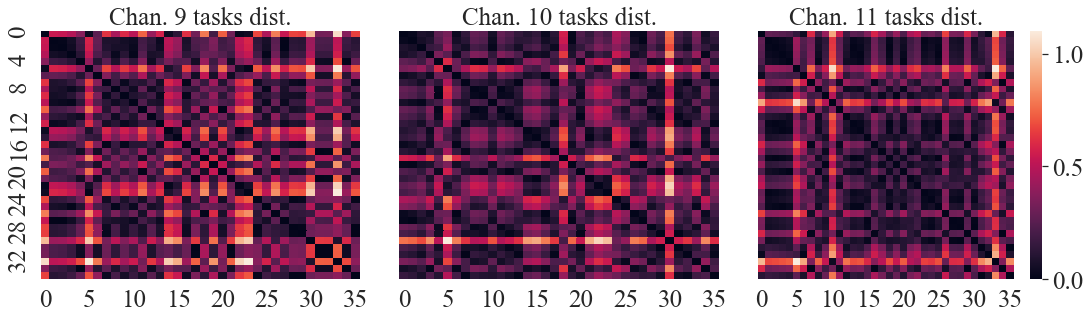

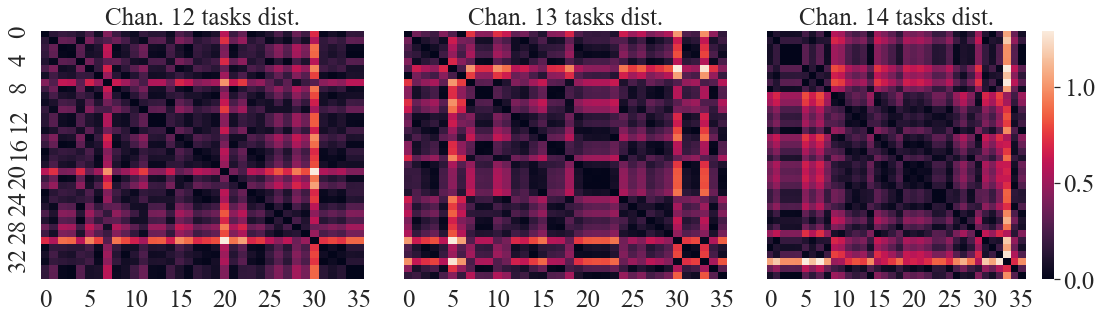

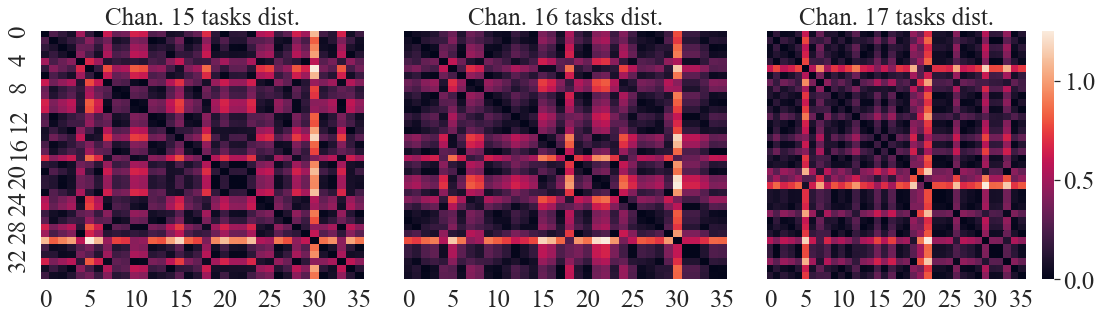

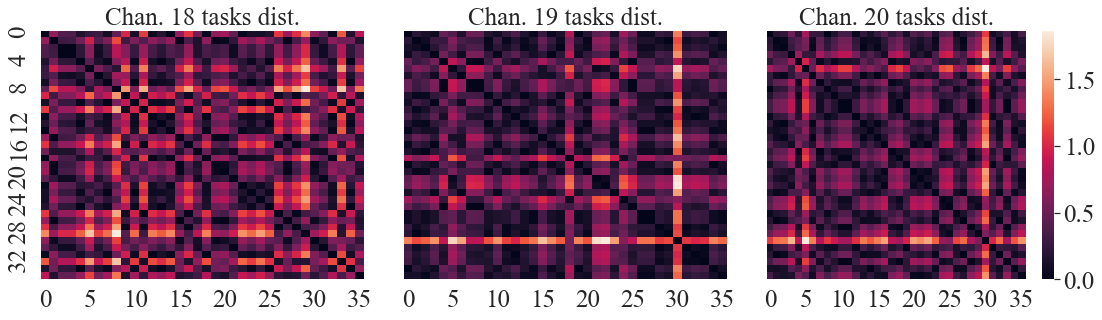

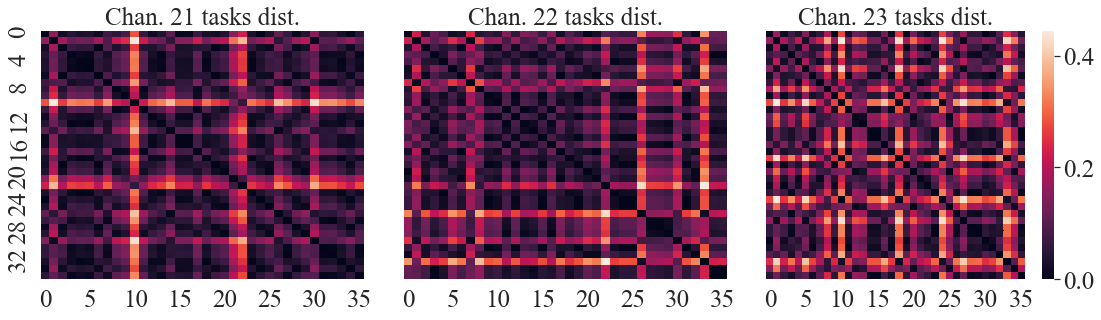

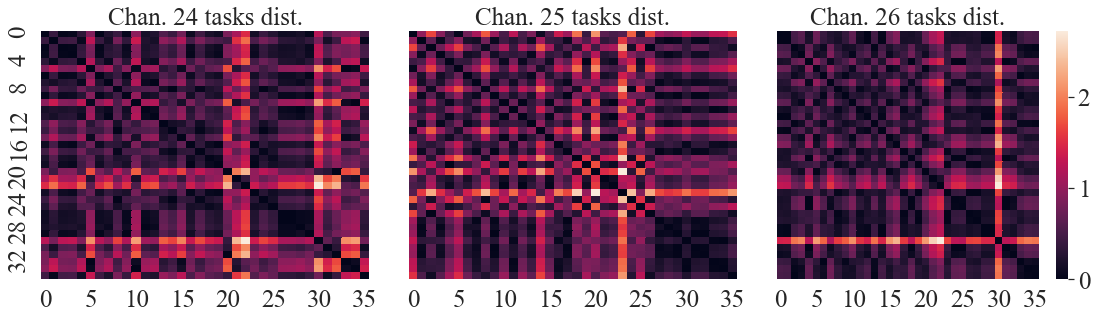

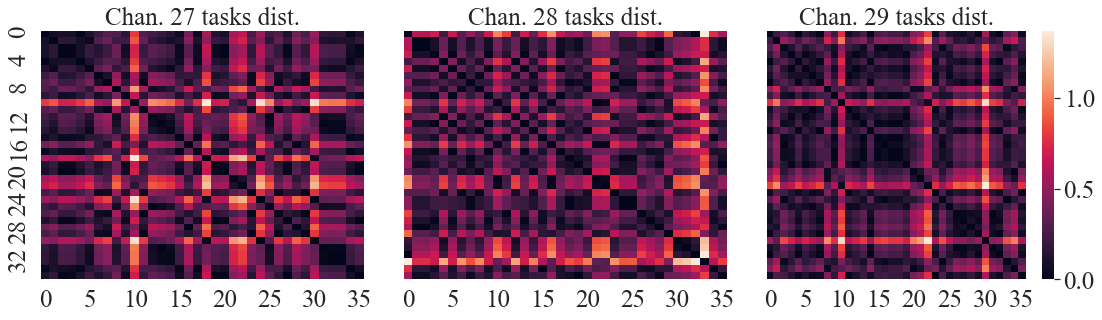

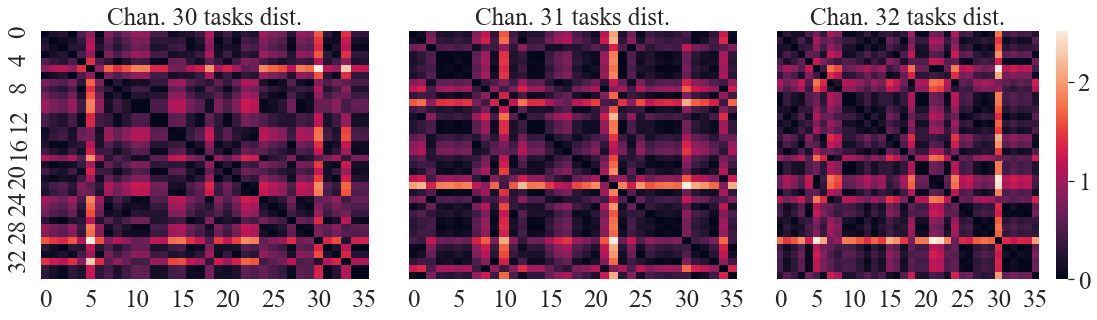

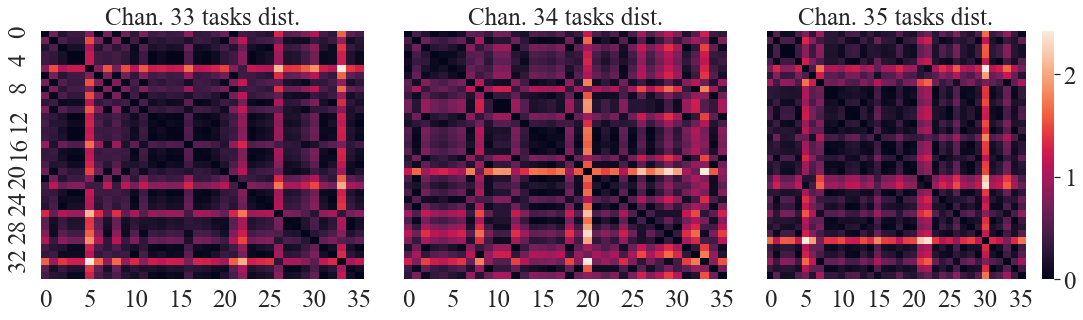

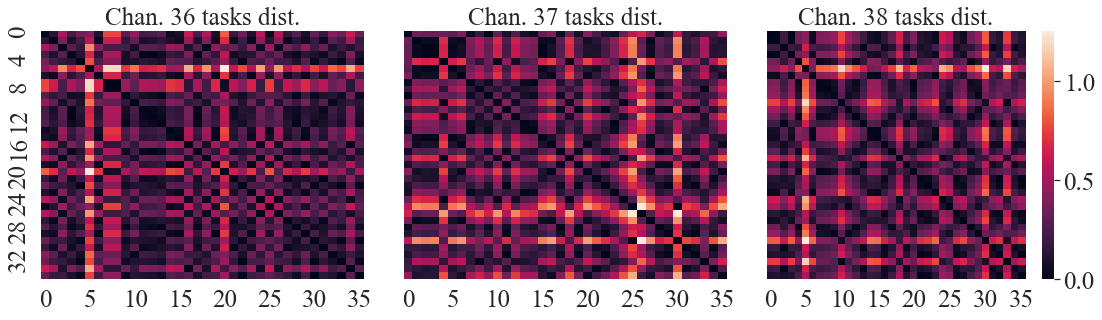

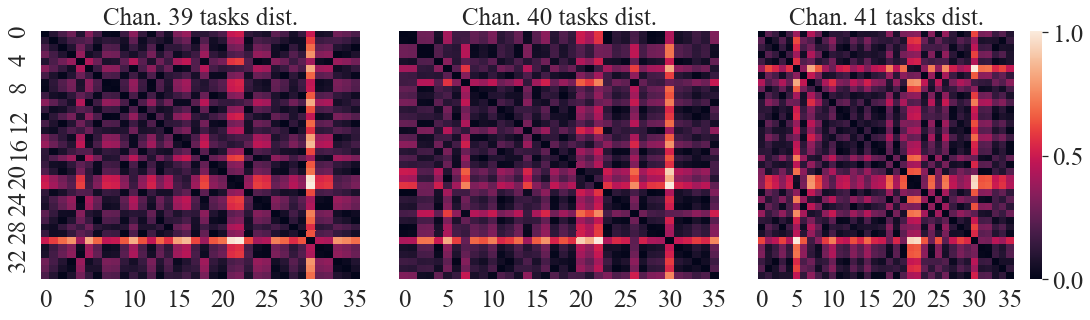

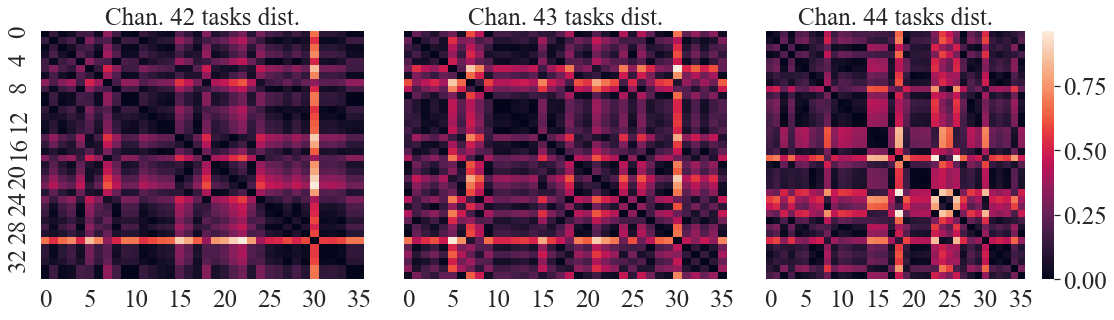

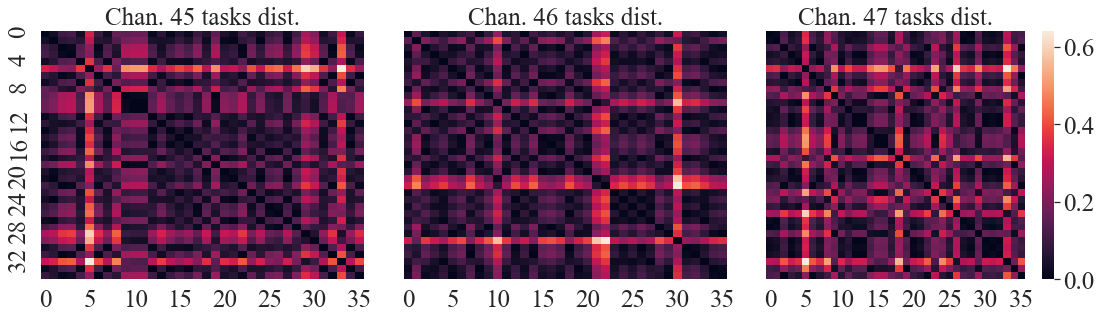

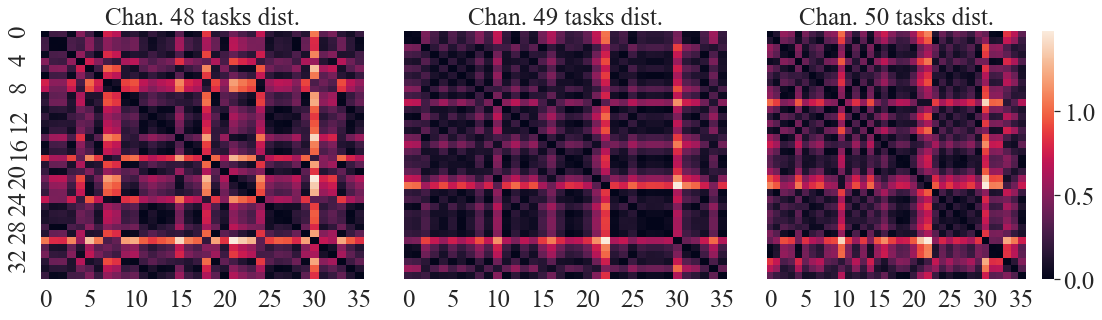

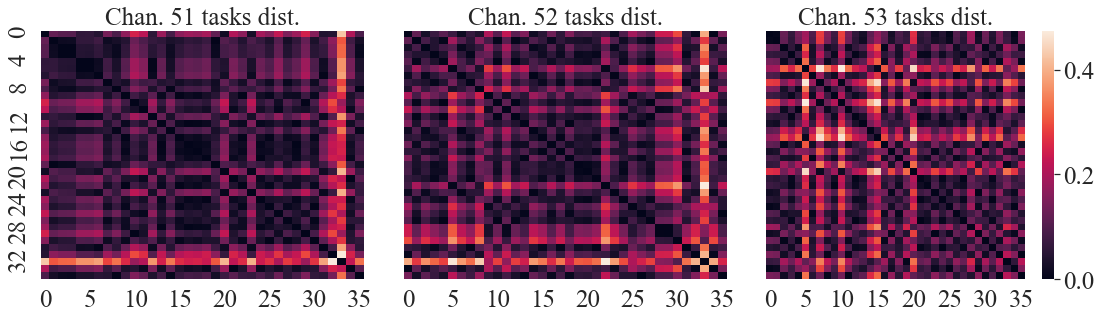

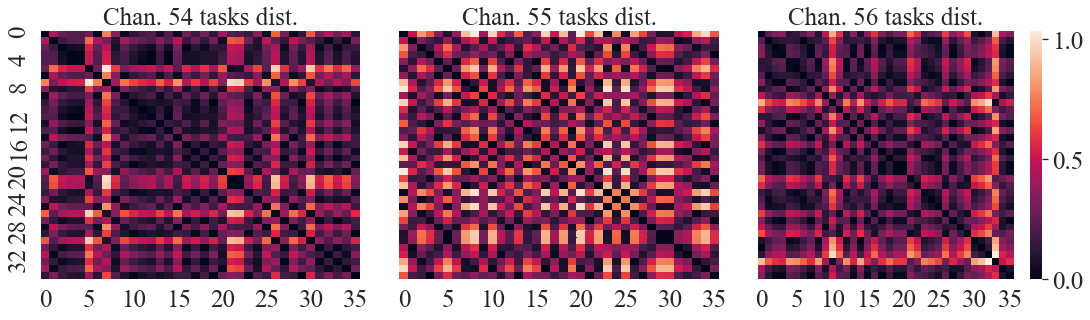

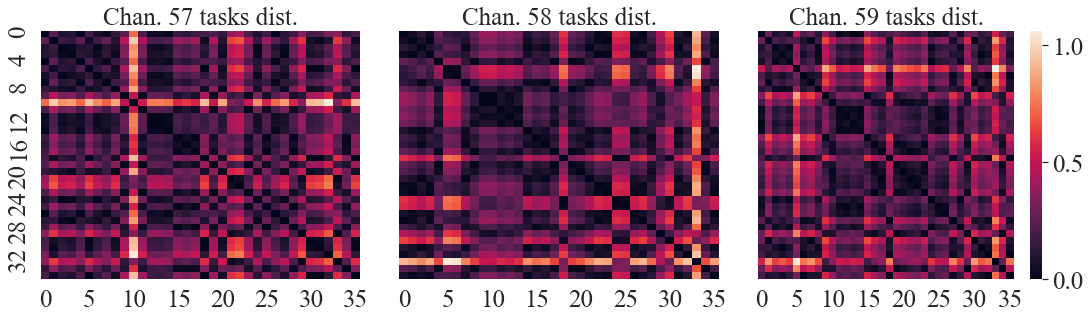

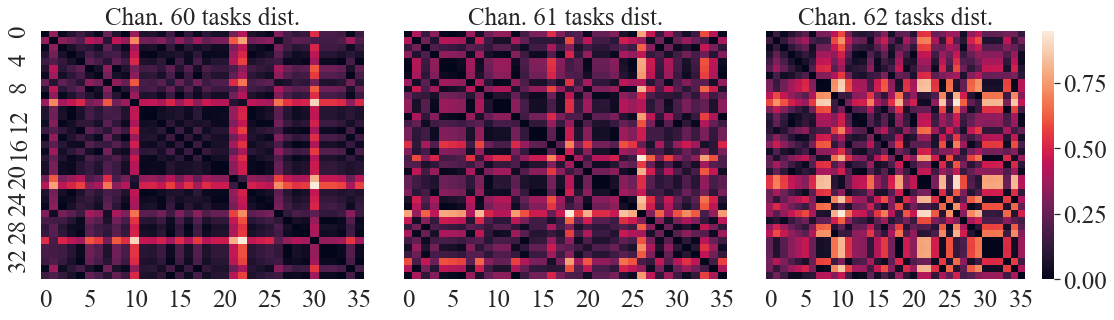

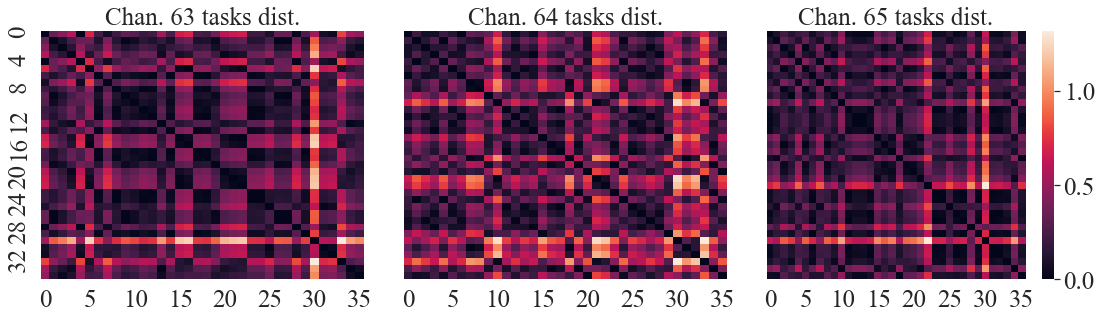

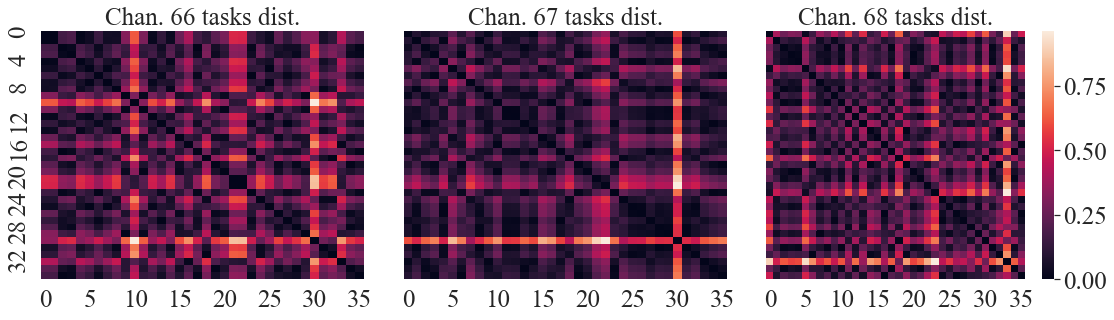

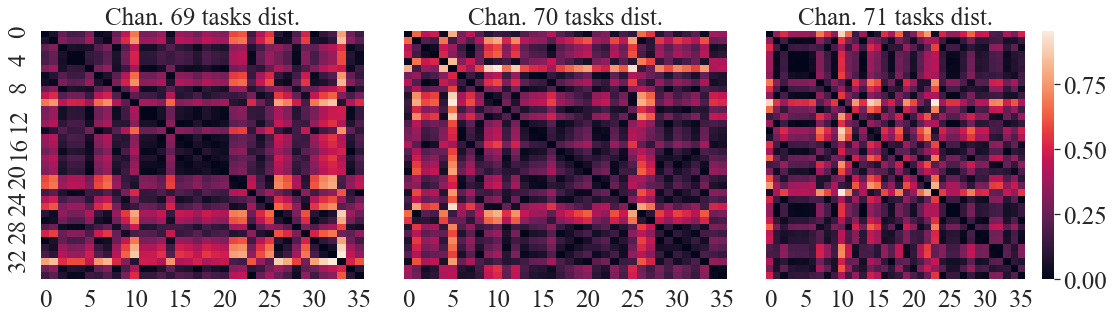

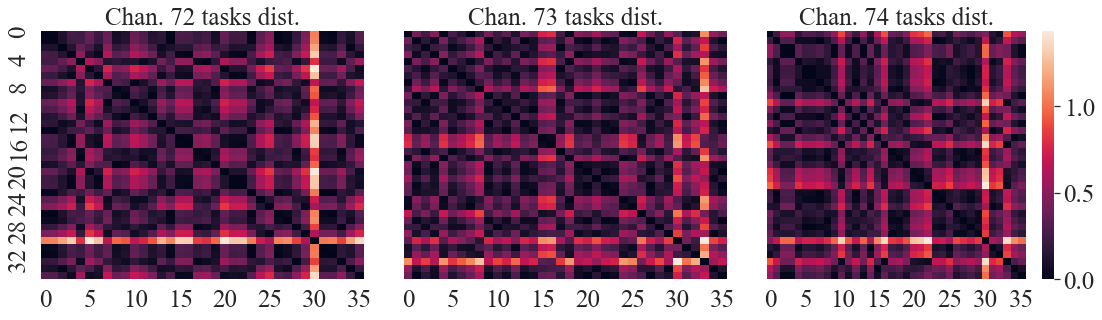

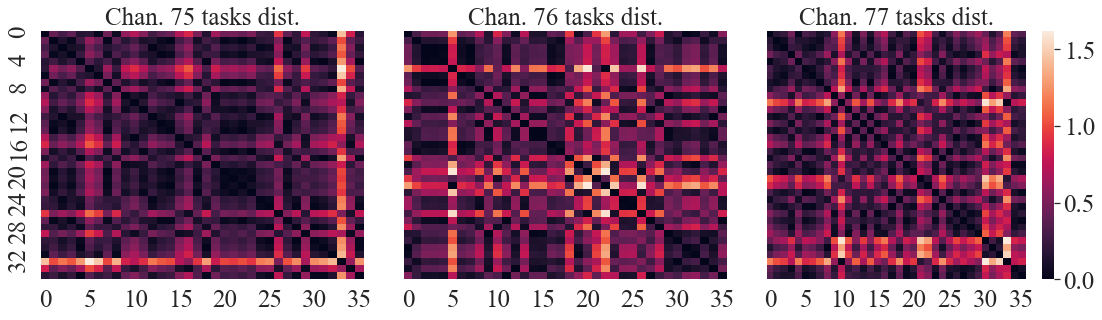

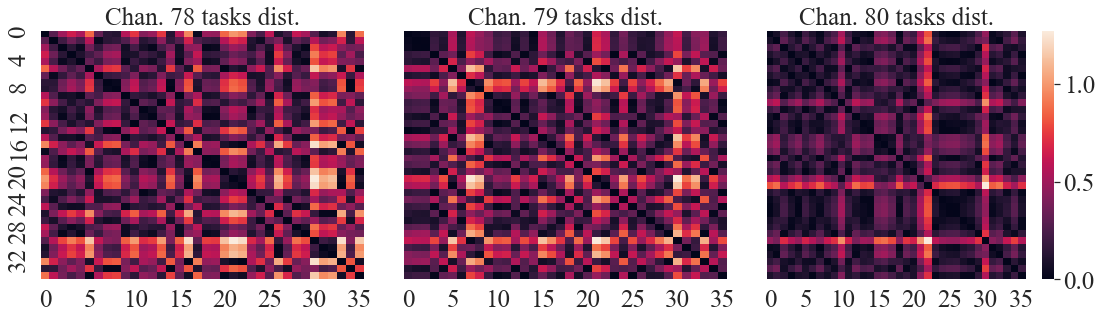

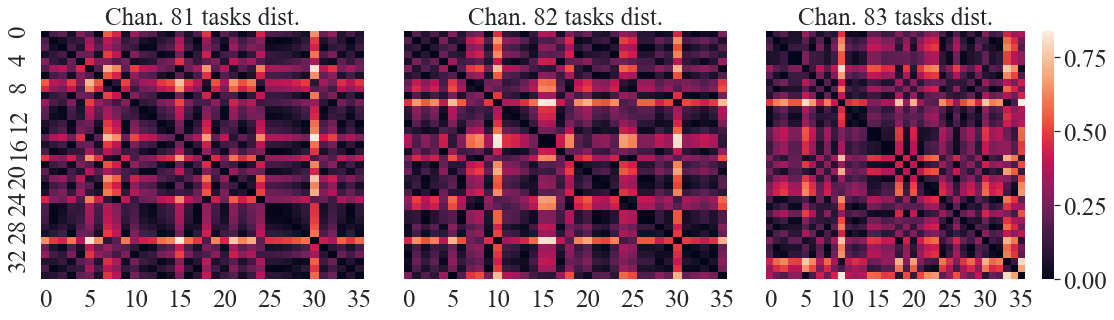

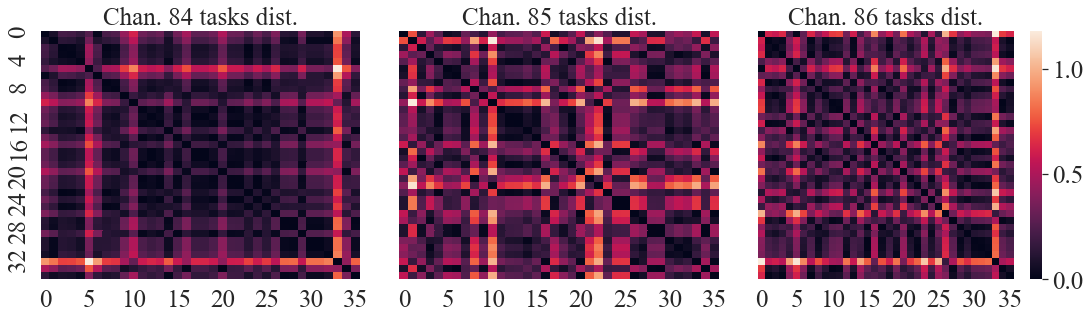

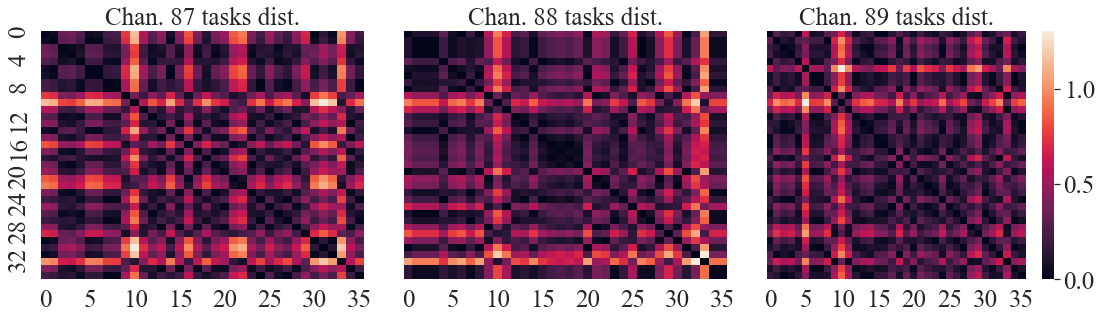

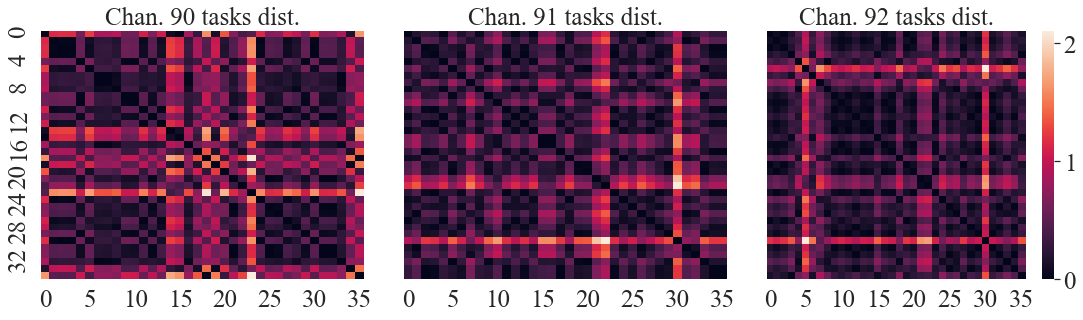

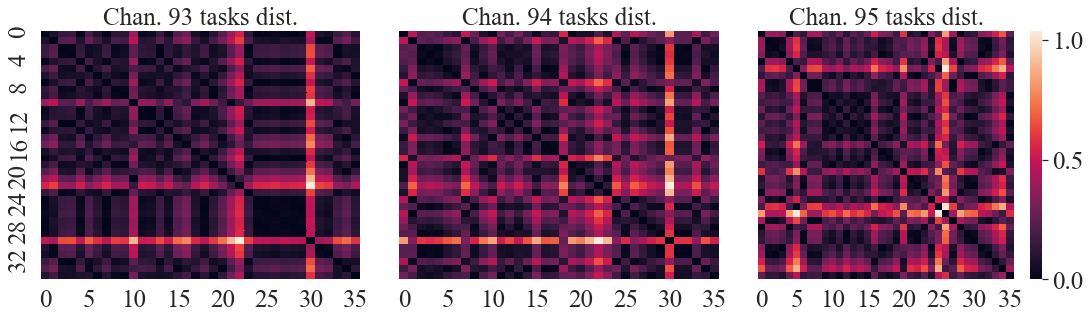

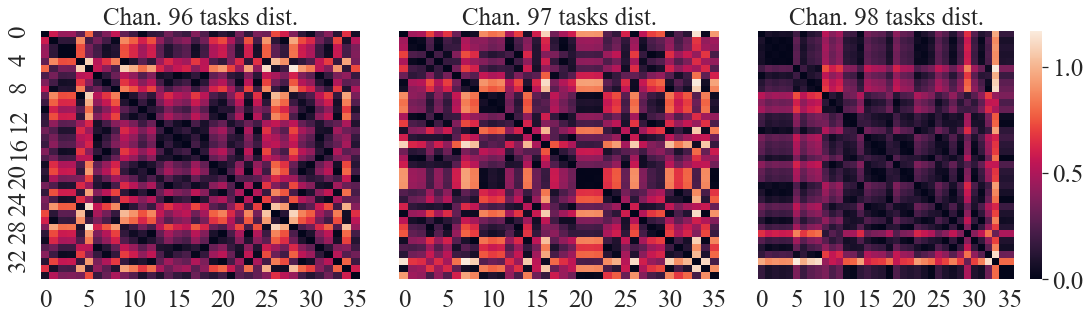

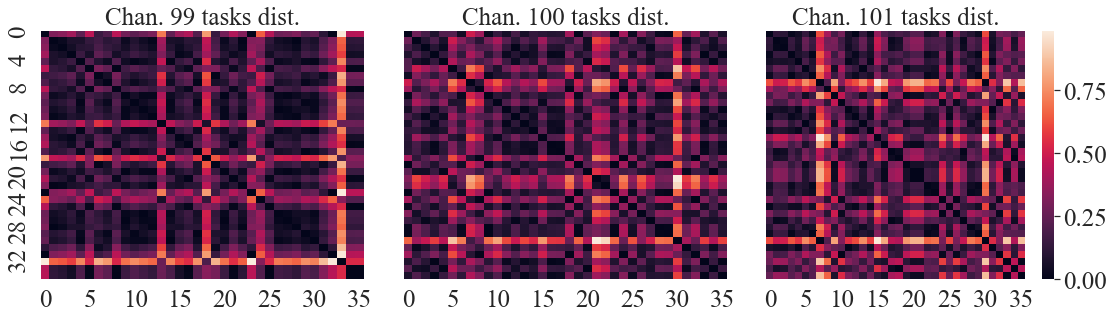

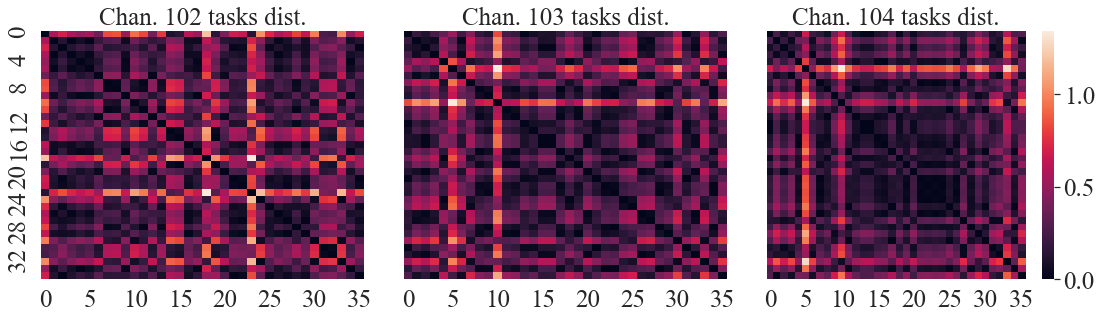

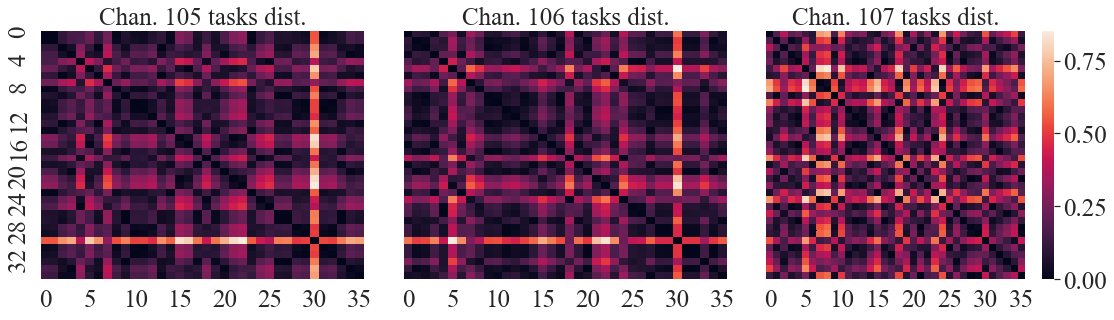

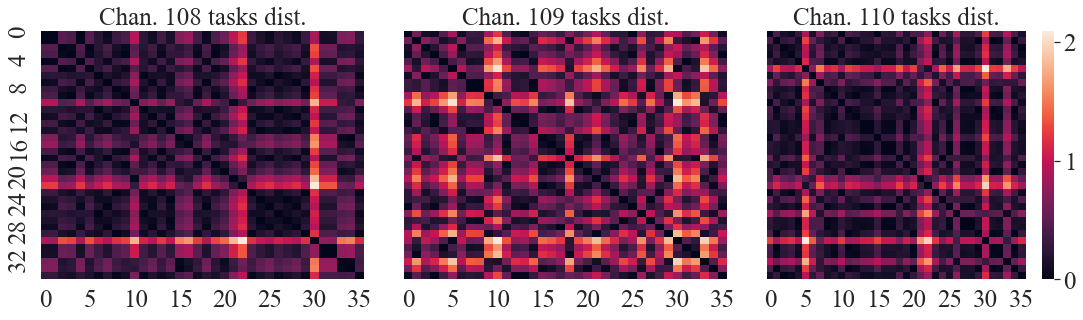

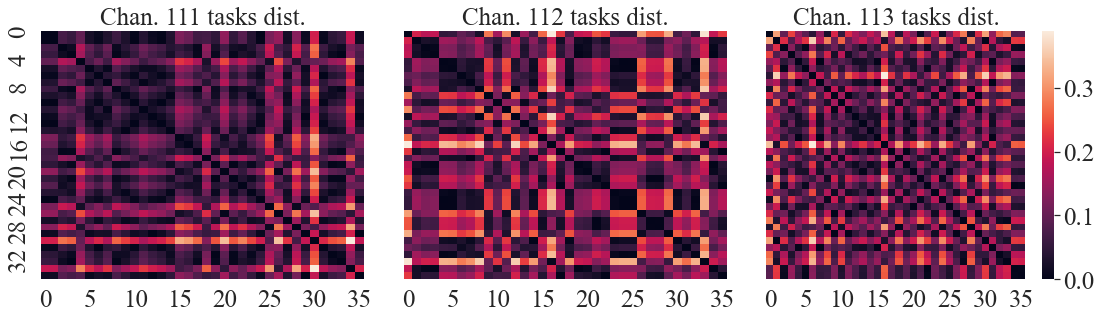

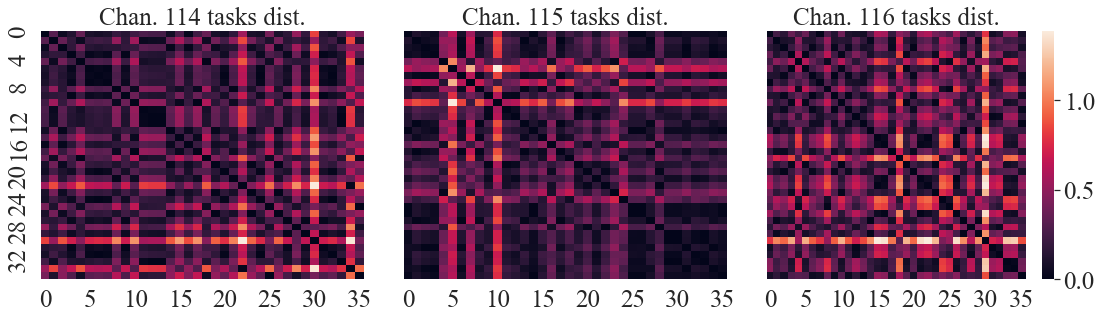

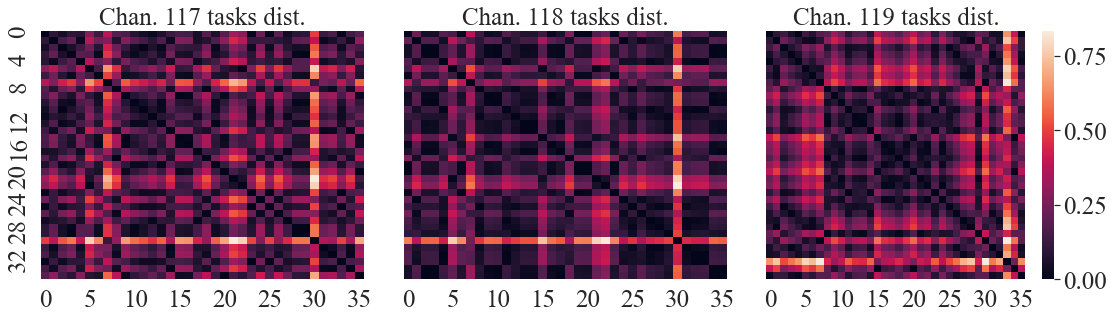

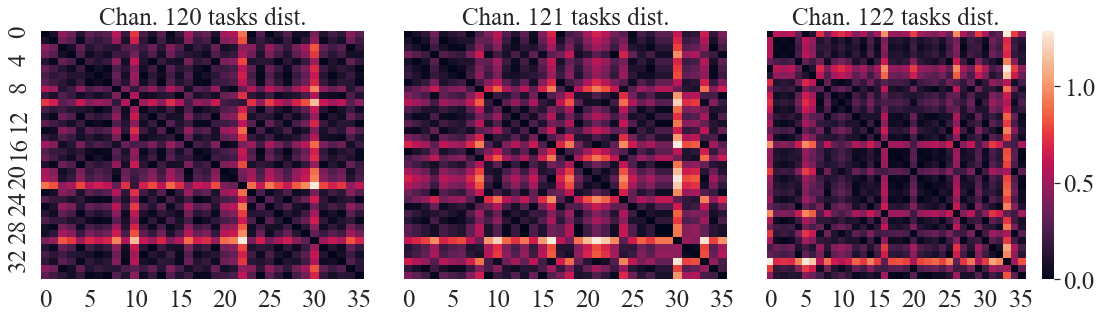

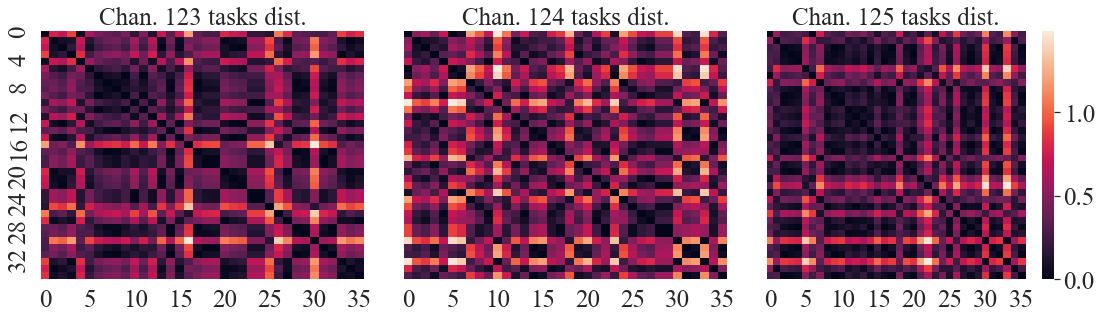

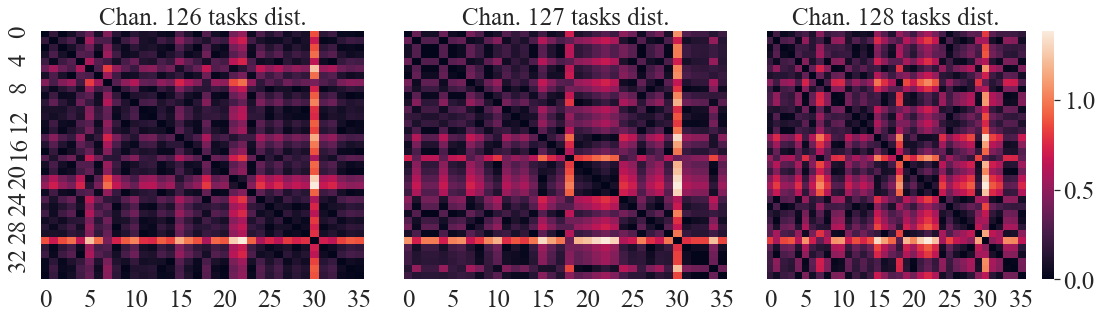

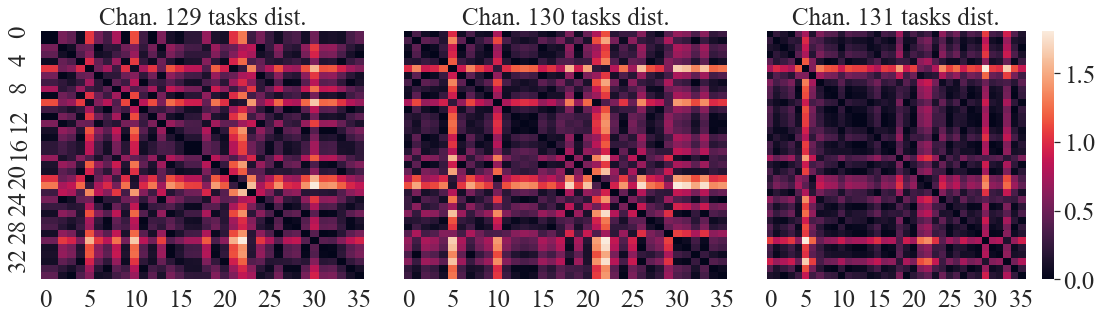

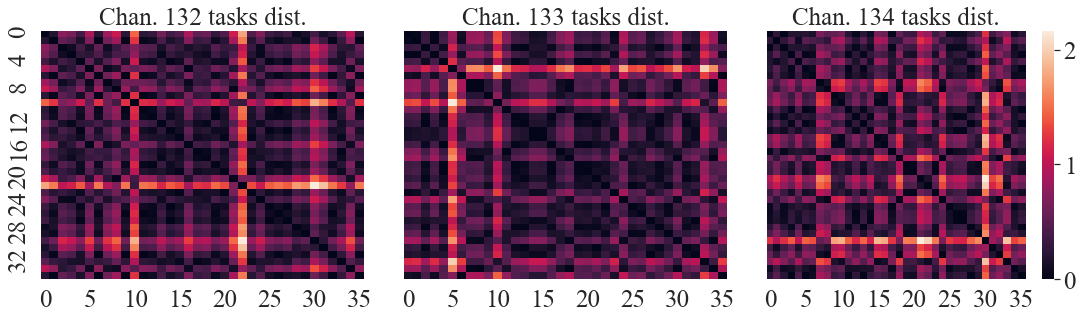

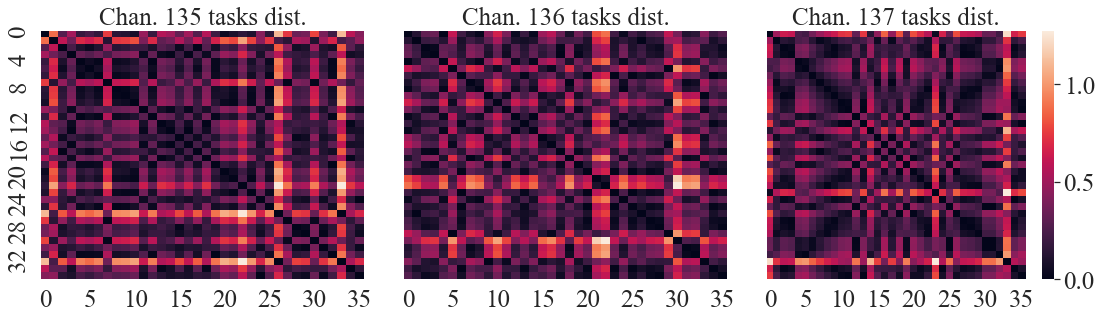

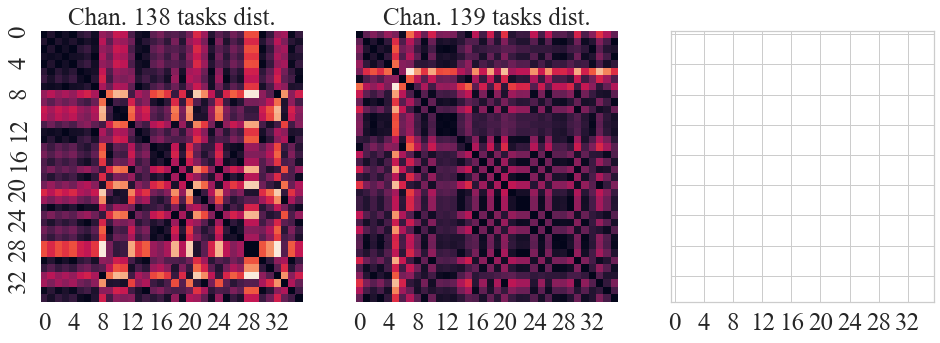

In [45]:
# num_channels = 12
num_cols=3
num_rows = 1

j = 0


for channel in range(0, num_channels):
    if j == 0:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16,5), sharex=True, sharey=True)
        
    d = pdist(latent_channelwise_embeddings[:,channel].reshape(-1,1), metric="euclidean")
    sns.heatmap(squareform(d), ax=axes[j], cbar=j == num_cols-1,)
#     sns.distplot(d, ax=axes[j] )
    axes[j].title.set_text(f"Chan. {channel} tasks dist.")

    j += 1
    if j == num_cols:
        
        plt.tight_layout()
        plt.savefig(f"../doc/figs/channel_dist_{channel:03d}.pdf")
        plt.show()
        j = 0
        
# closer to zero means: "what is added" is closer/more similar        